In [4]:
import os
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import warnings

In [5]:
# ignore warnings
warnings.filterwarnings('ignore')

# tqdm apply to pandas
tqdm.pandas()

# default paleets change
sns.set_palette('pastel')

# seaborn palettes
qualitative_colors = sns.color_palette('Set3', 10)
sequential_colors = sns.color_palette('RdPu', 10)
diverging_colors2 = sns.color_palette("RdBu", 2)
diverging_colors10 = sns.color_palette('RdBu', 10)

%matplotlib inline

In [6]:
TRAIN_DATA_PATH = '../input/data/train/train.csv'
TRAIN_IMG_PATH = '../input/data/train/images/'
SUBMISSION_PATH = '../input/data/eval/info.csv'
EVAL_IMG_PATH = '../input/data/eval/images/'

In [7]:
train = pd.read_csv(TRAIN_DATA_PATH)
train.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [9]:
print(f"train 데이터 갯수 : {len(train)}")  

train 데이터 갯수 : 2700


In [10]:
train.isnull().sum()

id        0
gender    0
race      0
age       0
path      0
dtype: int64

train 데이터셋을 간단하게 살펴보면 우선 결측치는 없는 것으로 확인됩니다.  

이미지 저장 경로도 확인할 수 있습니다. 이미지 경로 양식은 id_gender_race_age입니다. 

## Basic EDA
![EDA](https://s3-ap-northeast-2.amazonaws.com/aistages-public-junyeop/app/Users/00000025/files/56bd7d05-4eb8-4e3e-884d-18bd74dc4864..png)

우리가 분류할 클래스는 **마스크 착용여부, 연령, 성별**을 고려한 총 18개입니다.  

간단한 마스크 착용/미착용이 아닌 연령과 성별에 맞춰 분류도 진행해야합니다.

train 데이터셋에는 총 5개의 컬럼이 존재합니다.

- id
- gender : 남성/여성
- race : 인종
- age : 분류 기준 - 30세 미만, 30세 이상 60세 미만, 60세 이상
- path

이미지를 직접 확인하기 전에 전반적인 이미지의 개수를 확인하고자 각 경로에 몇 개의 사진들이 존재하는지 가져와서 train 데이터프레임에 추가하겠습니다.  



In [11]:
def get_img_list(path):
    img_list = os.listdir(TRAIN_IMG_PATH+path)
    ret = [img for img in img_list if '._' not in img]
    return ret

train['img_count'] = train['path'].apply(lambda x: len(get_img_list(x)))
train.describe()

,age,img_count
count,2700.000000,2700.0
mean,37.708148,7.0
std,16.985904,0.0
min,18.000000,7.0
25%,20.000000,7.0
50%,36.000000,7.0
75%,55.000000,7.0
max,60.000000,7.0


실제 파일 경로를 os.listdir(path)로 찍어보면 14개로 나옵니다.  

하지만 이 중 7개의 데이터는 사진이 아닌 데이터이므로 전처리 진행 후 실제 이미지로 기록된 파일만 받아오겠습니다.  

모든 경로의 이미지가 7장인 것을 알 수 있습니다. 다행히 별 특이한 것은 크게 없네요.  

대회의 데이터 소개 페이지에 따르면 모든 클래스에 대해 5장의 마스크 착용, 1개의 미착용, 1개의 비정상 착용으로 고르게 있다고 합니다.  
<br/><br/>
하지만 다르게 말하면 마스크 착용과 미착용, 비정상 착용의 불균형이 존재한다는 의미입니다.  

총 2700명의 사진 중 5개가 마스크 착용이고 1개가 미착용, 1개가 비정상 착용이면 전체 데이터의 70%가 마스크 착용 비율이 됩니다.  

자세한 내용은 아래에서 설명하겠습니다.

그렇다면 연령대, 성별에 대한 불균형이 존재하는지 확인하고자 train 데이터셋의 간단한 분석을 진행하겠습니다.

Age

실제 나이의 분포를 확인하기 전에 대회에서 요구하는 연령대로 구분한 컬럼을 추가하겠습니다.

In [12]:
def get_age_range(age):
    if age < 30:
        return "< 30"
    elif age >= 30 and age < 60:
        return ">= 30 and < 60"
    elif age >= 60:
        return ">= 60"

train['age_range'] = train['age'].apply(lambda x : get_age_range(x))

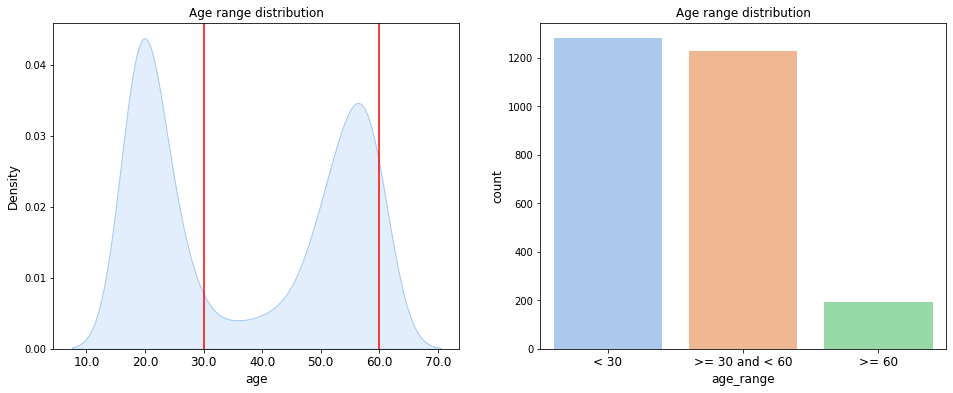

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

g1 = sns.kdeplot(data=train, x='age', fill=True, alpha=0.3, ax=ax[0])
ax[0].axvline(30, c='red')
ax[0].axvline(60, c='red')
g2 = sns.countplot(data=train, x='age_range', ax=ax[1], order=['< 30', '>= 30 and < 60', '>= 60'])

ax[0].set_xticklabels(g1.get_xticks(), fontsize=12)
ax[0].set_xlabel(g1.get_xlabel(), fontsize=12)
ax[0].set_ylabel(g1.get_ylabel(), fontsize=12)
ax[0].set_title('Age range distribution')

ax[1].set_xticklabels(g2.get_xticklabels(), fontsize=12)
ax[1].set_xlabel(g2.get_xlabel(), fontsize=12)
ax[1].set_ylabel(g2.get_ylabel(), fontsize=12)
ax[1].set_title('Age range distribution')
plt.show()

예상대로 30세 미만과 60세 미만의 데이터는 충분하지만 60세 이상의 데이터가 상당히 불균형한 것을 볼 수 있습니다. 이 부분에 대해 data augmentation이 필요할 것 같습니다.  

특이한 점은 30대 ~ 약 45세 구간의 데이터의 분포가 떨어지는 것을 알 수 있습니다.  

>= 30 and < 60의 분포에서 많은 수는 50 ~ 60세로 추정되므로 30, 40대의 data augmentation이 필요할 것으로 보입니다.  

연령대에 대한 data augmentation을 처리하는게 이번 대회 성능의 key로 작용할 수 있을 것으로 보입니다.


## Gender

이번에는 성별과 관련된 데이터의 분포를 확인하겠습니다.



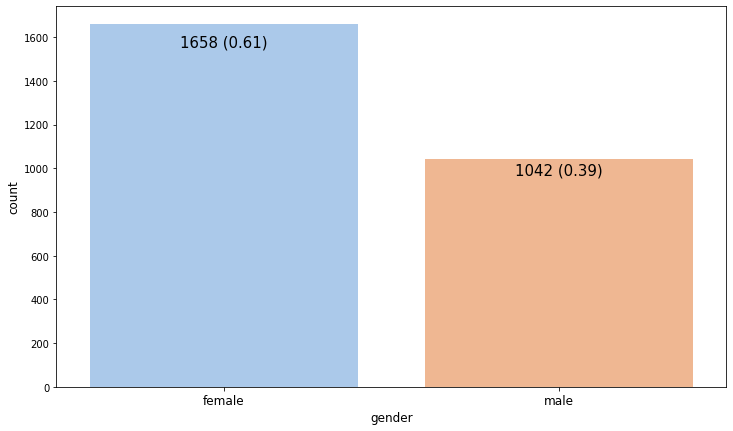

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

g = sns.countplot(data=train, x='gender', ax=ax)

for p in g.patches:
    g.annotate(f"{p.get_height()} ({(p.get_height()/len(train)):.2g})", (p.get_x()+p.get_width()/2., (p.get_height()+0.01)*0.95),
                  ha='center', va='center', fontsize=15)

ax.set_xticklabels(g.get_xticklabels(), fontsize=12)
ax.set_xlabel(g.get_xlabel(), fontsize=12)
ax.set_ylabel(g.get_ylabel(), fontsize=12) 
plt.show()

연령에 비해 불균형이 심한 편은 아니지만 그래도 여성이 남성보다 1.5배 정도 많은 수의 데이터를 갖고 있습니다.  

성능의 추가적인 개선을 필요로 할 때 고려해볼 수도 있습니다.  

문제는 연령대 분포가 많이 불균형했었습니다. 이를 고려해서 데이터 증강을 할 수 있지 않을까요?  

이번에는 연령대별 성별 분포도 확인하겠습니다.

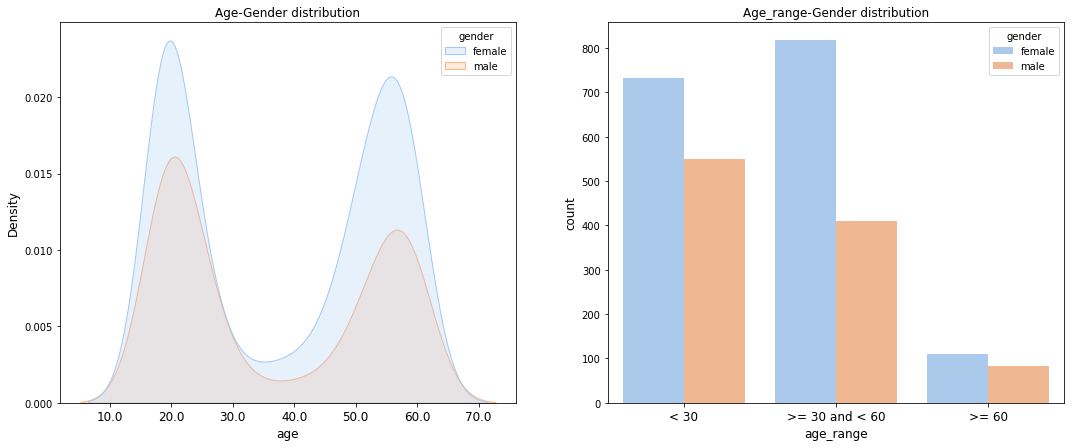

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

g1 = sns.kdeplot(data=train, x='age', hue='gender', fill=True, ax=ax[0])
g2 = sns.countplot(data=train, x='age_range', hue='gender', order=['< 30', '>= 30 and < 60', '>= 60'], ax=ax[1])

ax[0].set_xticklabels(g1.get_xticks(), fontsize=12)
ax[0].set_xlabel(g1.get_xlabel(), fontsize=12)
ax[0].set_ylabel(g1.get_ylabel(), fontsize=12)
ax[0].set_title('Age-Gender distribution')

ax[1].set_xticklabels(g2.get_xticklabels(), fontsize=12)
ax[1].set_xlabel(g2.get_xlabel(), fontsize=12)
ax[1].set_ylabel(g2.get_ylabel(), fontsize=12)
ax[1].set_title('Age_range-Gender distribution')

plt.show()

그나마...? 다행이라고 볼 수 있는 점은 연령에 따른 성별의 분포의 형태가 다르지 않다는 것입니다.  

물론..... 여전히 중간 부분에 불균형이 존재하지만 전반적인 두 분포는 형태가 비슷해 보입니다.  

하지만 그래도 >= 30 and < 60 구간은 약 2배정도의 데이터 불균형이 있습니다.


## Class imbalance

데이터 소개에 따르면 데이터의 정보는 다음과 같습니다. 

마스크를 착용하는 건 COIVD-19의 확산을 방지하는데 중요한 역할을 합니다. 제공되는 이 데이터셋은 사람이 마스크를 착용하였는지 판별하는 모델을 학습할 수 있게 해줍니다. 모든 데이터셋은 아시아인 남녀로 구성되어 있고 나이는 20대부터 70대까지 다양하게 분포하고 있습니다. 간략한 통계는 다음과 같습니다.

- 전체 사람 명 수 : 4,500

- 한 사람당 사진의 개수: 7 [마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장]

- 이미지 크기: (384, 512)

- 전체 데이터셋 중 60%(2700명)는 학습셋으로 사용됩니다.

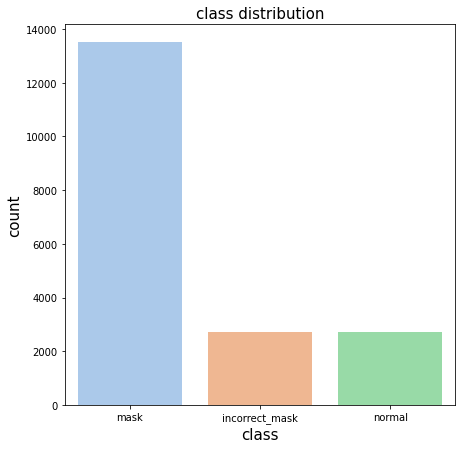

In [16]:
total = len(train) * 7
labels = ['mask', 'incorrect_mask', 'normal']
val = [(len(train)*5), (len(train)*1), (len(train)*1)]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

g = sns.barplot(x=labels, y=val)

ax.set_xlabel('class' , fontsize=15)
ax.set_ylabel('count', fontsize=15)
ax.set_title('class distribution', fontsize=15)
plt.show()

이 경우 다양한 방법을 통해 **마스크 착용이 아닌 데이터**의 증강을 고려해볼 필요는 반드시 있습니다.


## Data Preview

### Data Sample Preview

대표적인 샘플 이미지 1개를 가져와서 확인해보겠습니다.

전반적인 이미지의 클래스는 총 7개로 다음과 같이 분류됩니다.

- 비정상적 마스크 착용
- - incorrect_mask : 코스크 또는 턱스크

- 정상 마스크 착용
- - mask1
- - mask2
- - mask3
- - mask4
- - mask5
- 마스크 미착용
- - normal: 마스크를 착용하지 않은 상태

In [24]:
# get sample train data
sample = train.sample()

In [25]:
sample_img_path = sample.path.values[0]
sample_img_list = [img for img in os.listdir(TRAIN_IMG_PATH+sample_img_path) if '._' not in img]
sample_img_list = sorted(sample_img_list)

In [26]:
ig = plt.figure(figsize=(18, 8))

for i, filename in enumerate(sample_img_list):
    img_path = TRAIN_IMG_PATH+'/'+sample_img_path+'/'+filename
    img = cv2.imread(img_path)
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(filename.split('.')[0], fontsize=15)
    
plt.tight_layout()
plt.show()

<Figure size 1296x576 with 0 Axes>

Class별 이미지 샘플

각 클래스별로 5개 샘플 이미지를 가져와서 확인해보겠습니다.

In [21]:
sample = train.sample(5)
sample_img_path = sample.path.values
img_list = []

for img in sample_img_path:
    lists = []
    imgs = [img for img in os.listdir(TRAIN_IMG_PATH+img) if '._' not in img]
    
    for data in imgs:
        path = TRAIN_IMG_PATH+img+'/'+data
        img_kind = data.split('.')[0]
        lists.append(path)
    lists = sorted(lists)
    img_list.append(lists)

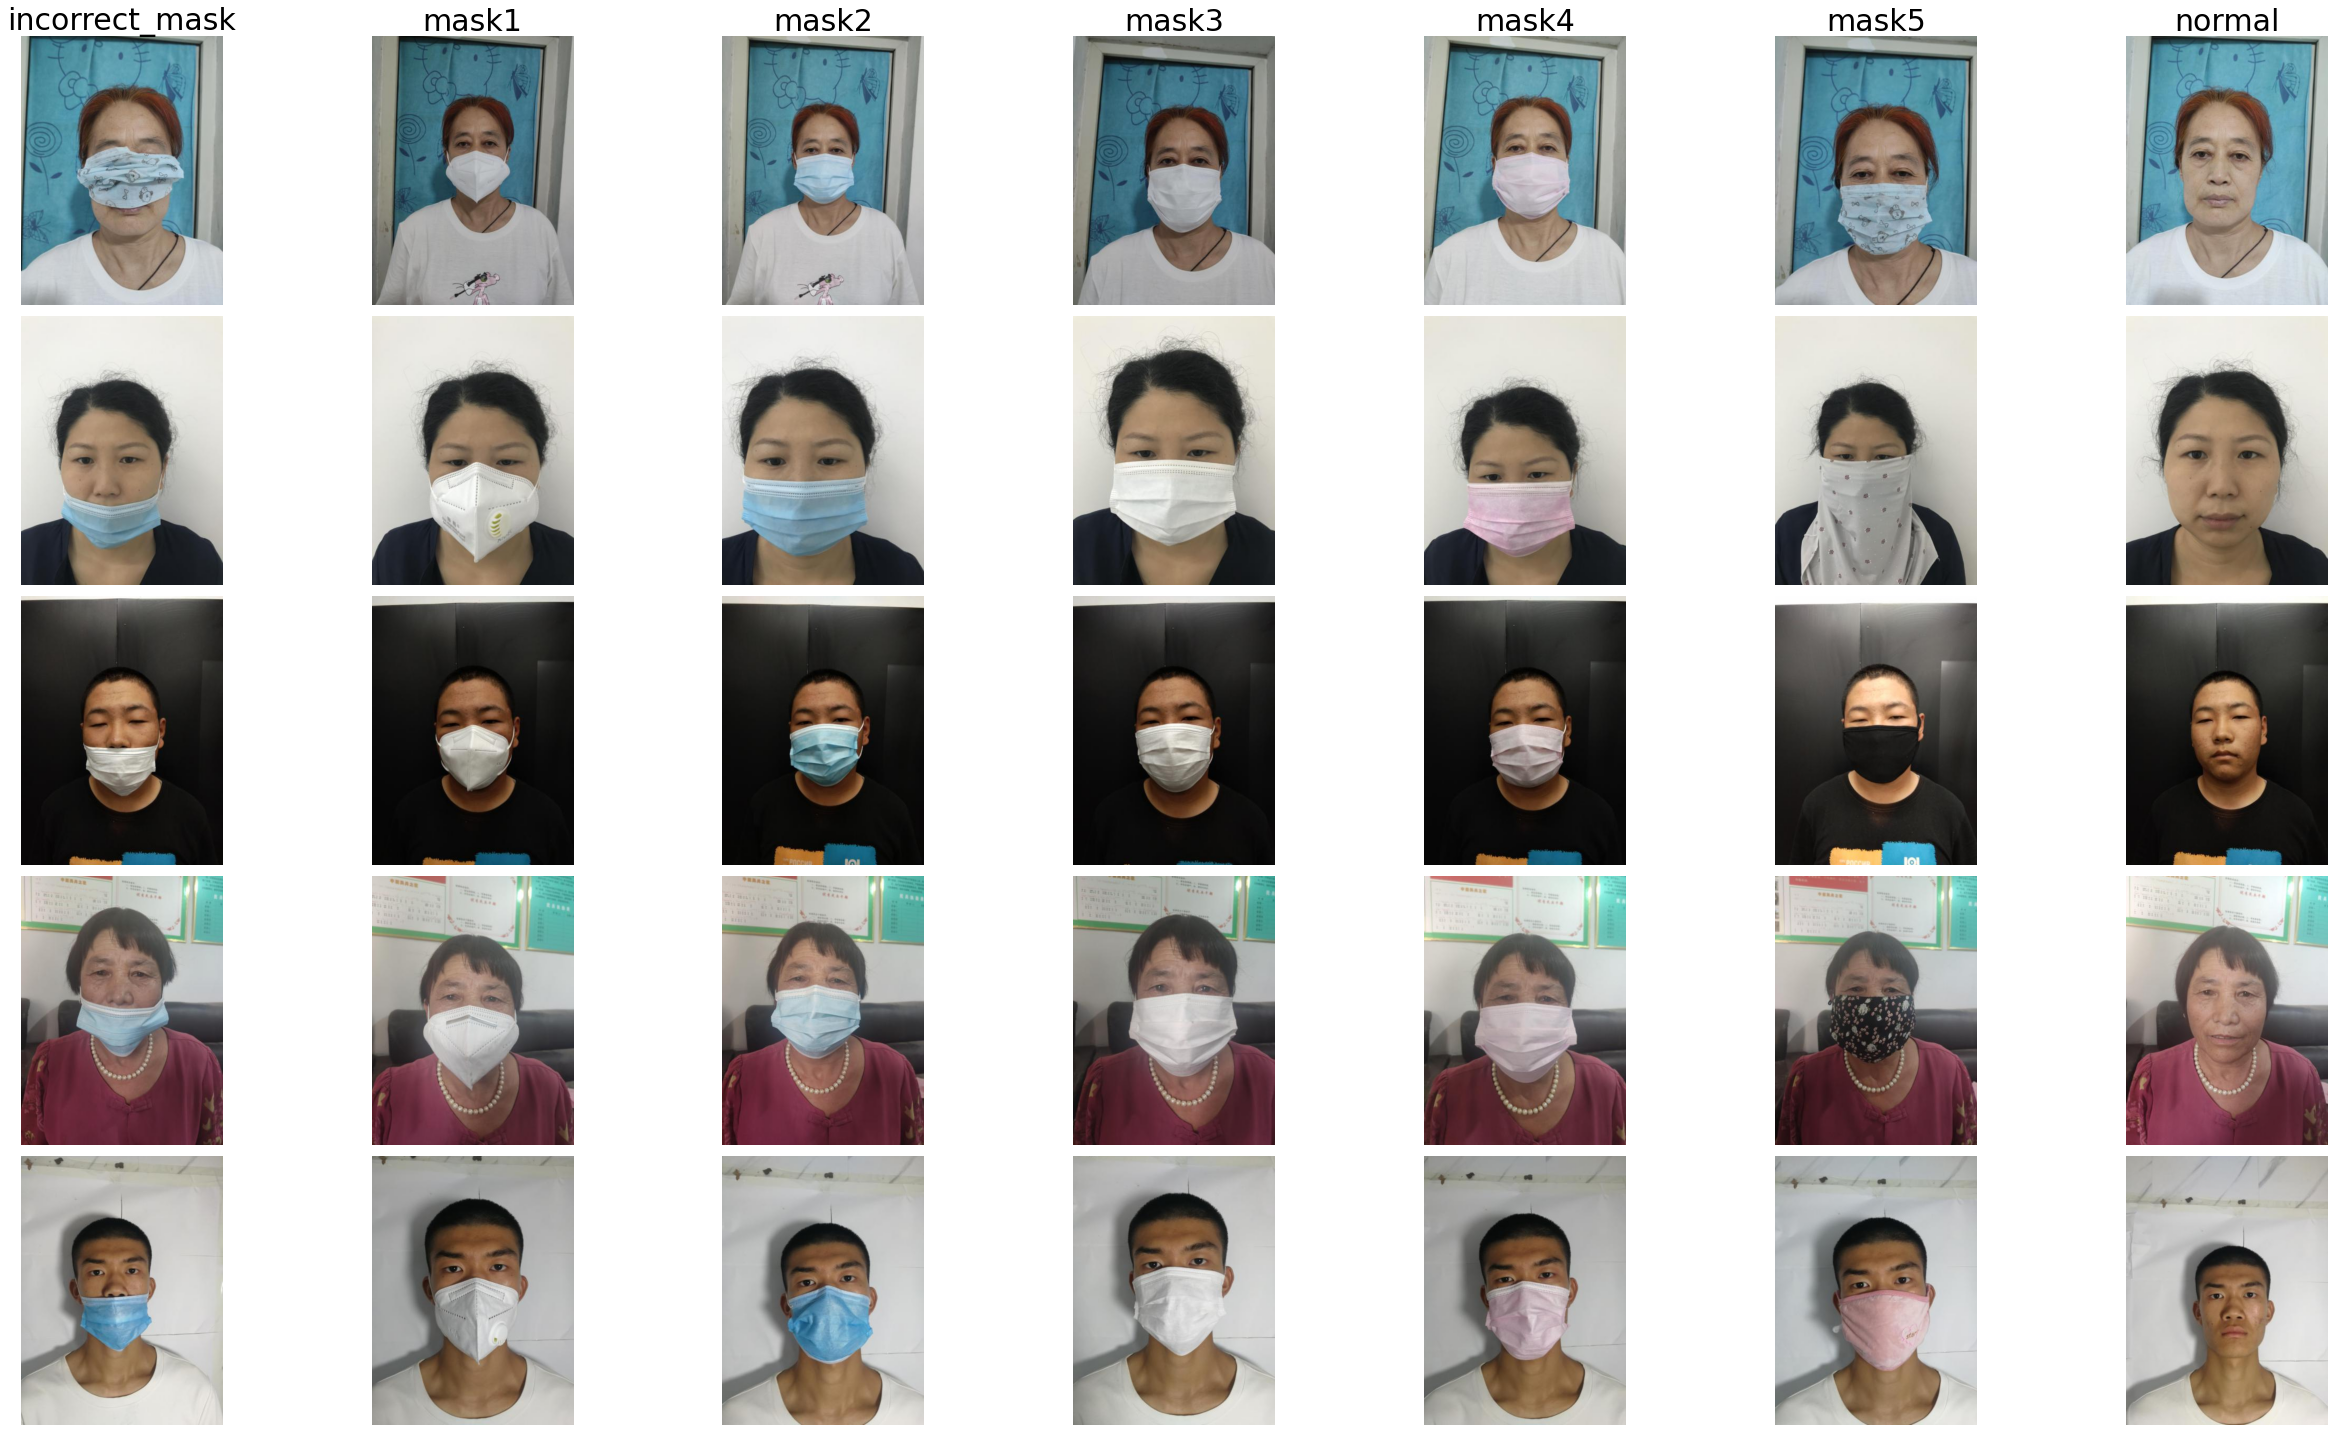

In [22]:
fig = plt.figure(figsize=(35, 20))

i=1

for files in img_list:
    for filename in files:
        img = cv2.imread(filename)
        ax = fig.add_subplot(5, 7, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        
        if i < 8:
            ax.set_title(filename.split('/')[-1].split('.')[0], fontsize=30)
        
        i += 1

plt.tight_layout()
plt.show()

막 특별?한 무언가는 보이지 않네요. 밝기에 대한 문제도 있고 여러가지로 전처리를 하는 게 좋을 것 같습니다.

## Conclusion and Discussions
간단하게 데이터에 대한 EDA를 진행해봤습니다.  

제가 EDA를 잘 하는 편도 아니고 이미지 분류 EDA를 해본 게 처음이라 제대로 한건지 모르겠네요 ^^;  


이번 EDA를 통해 나온 결과는 다음과 같습니다.
1. 마스크 착용, 미착용, 비정상 착용의 클래스 불균형이 심하다
2. 연령대 분포에서 30세 이상 60세 미만 데이터에서 분포가 고르지 못한 경향이 발생
3. 60세 이상과 30~40대 데이터의 augmentation이 필요할 것으로 보임